# Objective

We've been tasked with creating a neural network model which utilizes image recognition to determine whether or not a patient has pneumonia based on their chest x-rays. 

## Obtaining Data

Let's start with what we know.

Pneumonia is an infection in the lungs, specifically the alveoli, and can be caused by viruses, bacteria, or fungi.  Aside from blood tests and analyzing sputum, chest x-rays are also helpful.  This is because x-rays have difficulty penetrating through the fluid that builds up in the alveoli, creating a cloudy image.

The obstacle here will be that x-rays range in clarity due to noise or movement. Pneumonia also ranges in severity.  Some cases may be so acute that, to the untrained eye, they would appear normal.  In light of this and the health concerns around pneumonia we'll be aiming for a **model with high recall** and as **high of an accuracy we can achieve**.  We will be using recall as our metric since the worst case scenario with a **False Positive** is that someone is unnecessarily prescribed antibiotics and possibly steroids for a week.  The worst case scenario for a **False Negative** is **death**, if left untreated.

## About the data


The data was downloaded from Kaggle.com and, upon inspection, the files are not only divided into separate folders for positive and negative cases, but also **split** into **training**, **test**, and **validation** sets.  This will save us some time during preprocessing.  

**How this affects preprocessing:** 

* We will still need to **check for class imbalances**  

* As stated, we will be **focusing on recall and accuracy** for our metrics

* As this dataset only contains images, we won't need to worry about NaN's, placeholders, or feature engineering.

# Loading Data

Let's go ahead and get started.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, os.path
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import keras_preprocessing
import datetime
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
import scipy
from PIL import Image
from scipy import ndimage
import cv2
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [2]:
# Retrieving data from the individual folders

labels = ['PNEUMONIA', 'NORMAL']

# For now
img_size = 100
def get_data(data_dir):
    """
    Input a directory to a folder containing containing a number of folders 
    equal to the number of predefined labels.
    
    Function uses predefined folder labels and image sizes to create paths to
    each image, read the images in grayscale, resize them, and append them to 
    a list.
    
    Outputs a numpy array 
    """
    
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), 
                                     cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, 
                                         (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
train = get_data('../Diagnosing-Pneumonia/chest_xray/train')
test = get_data('../Diagnosing-Pneumonia/chest_xray/test')
val = get_data('../Diagnosing-Pneumonia/chest_xray/val')

In [4]:
print('Training Sample Size: ', train.shape[0])
print('Validation Sample Size: ', val.shape[0])
print('Testing Sample Size: ', test.shape[0])

Training Sample Size:  5216
Validation Sample Size:  16
Testing Sample Size:  624


And here we have our shapes for each of our sets:

Training Set Shape: (5216, 2)

Validation Set Shape: (16, 2)

Testing Set Shape: (624, 2)

This gives us a **grand total of 5,856 images** in total.  Under different circumstances, I would say that this **split ratio** is going to lead to **model over-fitting** (it still might if we're not careful). Though, given the **nature of neural networks** and the **amount of noise** that is in some of these images, we'll start with this **90/10 split** of the data for now.  

## Checking for Class Imbalance

In [5]:
import seaborn as sns
sns.set_style('darkgrid')

def class_counts(array):
    """
    Input an array object that contains two separate arrays.
    
    Function creates an empty list, loops through the arrays and appends the 
    list with either "Positive" if the data came from the 
    Pneumonia folder, or "Negative" if it came from the Normal folder.
    
    Lastly, it takes this list and plots the number of counts for each label,
    and prints the number of values in each class
    
    """
    labels = []
    for i in array:
        # Pneumonia cases are indexed first
        if i[1] == 0:
            labels.append('Pneumonia')
        else:
            labels.append('Normal')
    sns.countplot(labels)

    positive = 0
    negative = 0
    
    for n in range(len(labels)):
        
        if labels[n] == 'Pneumonia':
            positive += 1
        if labels[n] == 'Normal':
            negative += 1
    
    print('Positive Cases: ', positive)
    print('Negative Cases: ', negative)

Positive Cases:  3875
Negative Cases:  1341


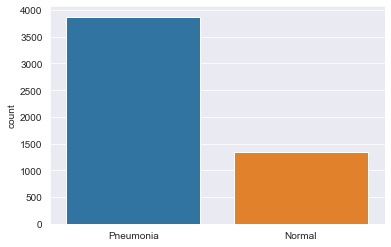

In [6]:
class_counts(train)

Here we go! Looks like the number of "Pneumonia" cases in our training set does outnumber the "Normal" cases. This may not be a bad thing since we want the model to have a lot of experience working with pneumonia cases. For now, we'll leave this as is.  If this does prove to be a problem, we'll try out data augmentation in another notebook. 

## Check Out Images

Real quick, lets see if our choice of image size is good enough.

Text(0.5, 1.0, 'Normal')

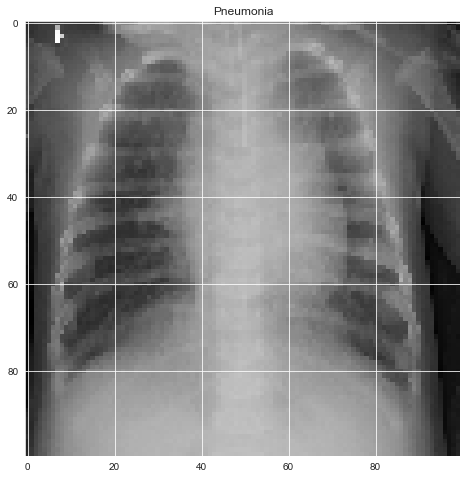

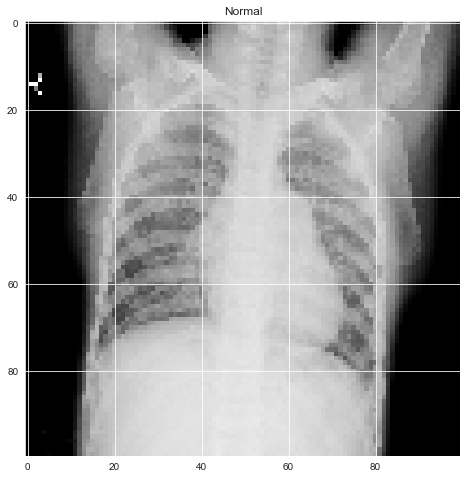

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(train[545][0], cmap='gray')
plt.title('Pneumonia')

plt.figure(figsize=(8,8))
plt.imshow(train[-254][0], cmap='gray')
plt.title('Normal')

Ok! As we mentioned at the beginning, there is going to be **a lot of noise** in some of these images, leading to **false positives**.  With that in mind, we might play around with resolution size when we reach a decent model performance, as the higher the resolution, the better.  

# Modeling Preparation

While, yes, we did load the data earlier, that was more for ease of accessing the data.  To make modeling easier, we're going to utilize the Keras tool, **ImageDataGenerator**, so we don't have to do all of this manually. To that end, we'll reload that data.

In [8]:
# Directories
import pathlib as Path

train_dir = 'chest_xray/train'
validation_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Rescaling
datagen = ImageDataGenerator(rescale=1./255) # rescaling the images 

# Generating Data
train_gen = datagen.flow_from_directory(train_dir, 
                    # Starting with 100x100 pixel images; subject to change
                    target_size=(100, 100),
                    batch_size=5216,
                    class_mode='binary')

val_gen = datagen.flow_from_directory(validation_dir, 
                    target_size=(100, 100),
                    batch_size=16,
                    class_mode='binary')

test_gen = datagen.flow_from_directory(test_dir, 
                    target_size=(100, 100),
                    batch_size=624,
                    class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
# Load the images and labels into their own respective files

train_img, train_labels = next(train_gen)
val_img, val_labels = next(val_gen)
test_img, test_labels = next(test_gen)

In [10]:
# Checking the image shape
print('Train Image Shape: ', train_img.shape)
print('Train Labels Shape: ', train_labels.shape)

Train Image Shape:  (5216, 100, 100, 3)
Train Labels Shape:  (5216,)


By passing in the class_mode argument to "binary", we won't need to reshape the labels.

# Baseline Model

We'll be utilizing a Convolutional Neural Networks (CNN) for our models.  CNNs utilize "filters" to detect edges and other objects to summarize and shrink the data (if you choose).  We'll also be able to add pooling layers which will summarize what the previous layer accomplished so that the model can build off of it in the next layer. Finally, we'll use fully connected (Dense) layers so that the neural network can do a thorough evaluation of the transformed (simplified) data.

In [12]:
np.random.seed(42)

model = models.Sequential()

# Due to the amount of noise in our data, we'll use a smaller filter of 3x3
# This time around we won't be using padding.
model.add(layers.Conv2D(50, (3,3), activation='relu', 
                        input_shape=(100, 100, 3)))
model.add(layers.MaxPooling2D((2,2)))


model.add(layers.Conv2D(50, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(75, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='sgd',
             metrics=['acc'])



In [13]:
# We'll start with a relatively low number of epochs and a larger batch size 
# for the sake of time

history = model.fit(train_img, train_labels, epochs=75, batch_size=250,
                   validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/75
5216/5216 [==============================] - 79s 15ms/step - loss: 0.5903 - acc: 0.7191 - val_loss: 0.8259 - val_acc: 0.5000
Epoch 2/75
5216/5216 [==============================] - 77s 15ms/step - loss: 0.5682 - acc: 0.7429 - val_loss: 0.8155 - val_acc: 0.5000
Epoch 3/75
5216/5216 [==============================] - 76s 15ms/step - loss: 0.5601 - acc: 0.7429 - val_loss: 0.8160 - val_acc: 0.5000
Epoch 4/75
5216/5216 [==============================] - 79s 15ms/step - loss: 0.5508 - acc: 0.7429 - val_loss: 0.7884 - val_acc: 0.5000
Epoch 5/75
5216/5216 [==============================] - 82s 16ms/step - loss: 0.5396 - acc: 0.7429 - val_loss: 0.7721 - val_acc: 0.5000
Epoch 6/75
5216/5216 [==============================] - 82s 16ms/step - loss: 0.5236 - acc: 0.7429 - val_loss: 0.7589 - val_acc: 0.5000
Epoch 7/75
5216/5216 [==============================] - 85s 16ms/step - loss: 0.5023 - acc: 0.7433 - val_loss: 0.7844 - val_acc: 0.5000
Ep

So far this doesn't look too bad for a baseline. It does look a little like it's **beginning to overfit** as indicated by the high training accuracy. The **validation metrics** are **fluctuating** a little too much for my liking, **especially** the **validation loss**.  This could be that there **weren't enough epochs**, but it could also be that there just **isn't enough validation data** for the model to find a pattern with. 

Let's go ahead and evaluate this model.

In [14]:
# Evaluating performance based on Training data
results_train = model.evaluate(train_img, train_labels)

5216/5216 [==============================] - 28s 5ms/step


In [15]:
# Evaluating performance on the Test data
results_test = model.evaluate(test_img, test_labels)

624/624 [==============================] - 3s 5ms/step


In [16]:
results_train

[0.1027064057626973, 0.9616564417177914]

In [17]:
results_test

[0.9241706606669303, 0.7227564102564102]

Well, there you have it! We've got **very high training accuracy**, some **mediocre testing accuracy**, and a **high testing loss** score!  Obviously, we need to tune the model, possibly **try fewer nodes**, but first lets just get a look at the plot of its performance over the course of the training time.

# Plotting Model Performance

In [18]:

def plot_performance(model):
    """
    Input a trained model.
    
    Outputs plots of the Training and Validation accuracy and loss.  
    """
    
    acc = model.history['acc']
    val_acc = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'blue', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'red', label='Validation Accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'blue', label='Training Loss')
    plt.plot(epochs, val_loss, 'red', label='Validation Loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

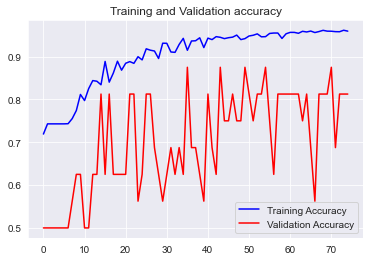

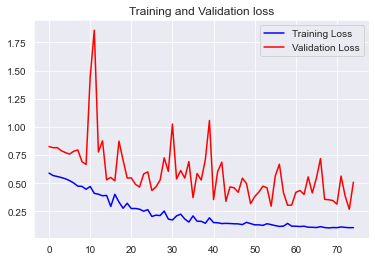

In [19]:
plot_performance(history)

### Evaluation

It appears that, given **more time**, the model would reach **greater convergence**.  Let's **add more epochs** to facilitate this. 

## Retry with More Epochs

In [20]:
# Increasing Epochs

np.random.seed(42)

model2 = models.Sequential()

model2.add(layers.Conv2D(50, (3,3), activation='relu', 
                        input_shape=(100, 100, 3)))
model2.add(layers.MaxPooling2D((2,2)))


model2.add(layers.Conv2D(50, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))

model2.add(layers.Conv2D(75, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(75, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))


model2.compile(loss='binary_crossentropy',
             optimizer='sgd',
             metrics=['acc'])

# We're going to let this run and see if we get better consistency
history2 = model2.fit(train_img, train_labels, epochs=125, batch_size=100,
                   validation_data=(val_img, val_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/125
5216/5216 [==============================] - 76s 15ms/step - loss: 0.5765 - acc: 0.7360 - val_loss: 0.9161 - val_acc: 0.5000
Epoch 2/125
5216/5216 [==============================] - 78s 15ms/step - loss: 0.5488 - acc: 0.7429 - val_loss: 0.8714 - val_acc: 0.5000
Epoch 3/125
5216/5216 [==============================] - 77s 15ms/step - loss: 0.5135 - acc: 0.7458 - val_loss: 0.9042 - val_acc: 0.5000
Epoch 4/125
5216/5216 [==============================] - 76s 15ms/step - loss: 0.4715 - acc: 0.7837 - val_loss: 0.9095 - val_acc: 0.5625
Epoch 5/125
5216/5216 [==============================] - 77s 15ms/step - loss: 0.4276 - acc: 0.8175 - val_loss: 0.8537 - val_acc: 0.5000
Epoch 6/125
5216/5216 [==============================] - 76s 15ms/step - loss: 0.3953 - acc: 0.8355 - val_loss: 0.7469 - val_acc: 0.6250
Epoch 7/125
5216/5216 [==============================] - 76s 15ms/step - loss: 0.3370 - acc: 0.8608 - val_loss: 0.5084 - val_acc: 0.

5216/5216 [==============================] - 86s 16ms/step - loss: 0.0349 - acc: 0.9877 - val_loss: 1.0755 - val_acc: 0.6875
Epoch 120/125
5216/5216 [==============================] - 84s 16ms/step - loss: 0.0334 - acc: 0.9885 - val_loss: 0.2487 - val_acc: 0.8750
Epoch 121/125
5216/5216 [==============================] - 83s 16ms/step - loss: 0.0323 - acc: 0.9887 - val_loss: 0.6355 - val_acc: 0.7500
Epoch 122/125
5216/5216 [==============================] - 84s 16ms/step - loss: 0.0308 - acc: 0.9900 - val_loss: 0.7699 - val_acc: 0.7500
Epoch 123/125
5216/5216 [==============================] - 84s 16ms/step - loss: 0.0313 - acc: 0.9891 - val_loss: 0.5876 - val_acc: 0.7500
Epoch 124/125
5216/5216 [==============================] - 83s 16ms/step - loss: 0.0307 - acc: 0.9900 - val_loss: 0.6378 - val_acc: 0.7500
Epoch 125/125
5216/5216 [==============================] - 83s 16ms/step - loss: 0.0315 - acc: 0.9898 - val_loss: 0.6684 - val_acc: 0.7500


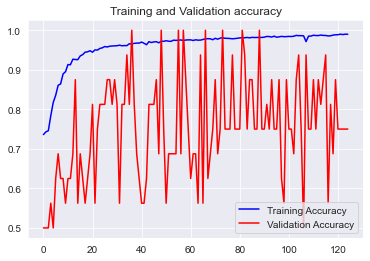

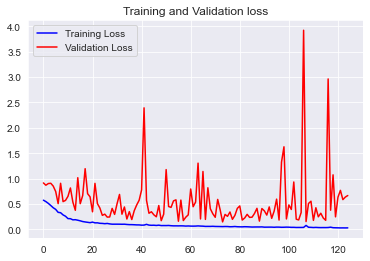

In [21]:
plot_performance(history2)

In [22]:
results_test2 = model2.evaluate(test_img, test_labels)

624/624 [==============================] - 4s 6ms/step


In [23]:
results_test2

[1.4422784035022442, 0.7355769230769231]

## Evaluation

That is **a lot of variance**... It appears that with more epochs and smaller batches, the results in the training and validation sets look like they are converging, **at first**.  As they **iterate** through **more epochs**, however, they begin to **diverge**.

Aside from over-fitting, there could just be too much noise.  Let's open another notebook and start and re-tune our parameters. 

**Continue to Modeling Book 2**